# Deep sets 

Notebook based on [DeepSetsAndGraphNetworks.ipynb from LMU course](https://github.com/fuenfundachtzig/LMU_DA_ML/blob/master/DeepSetsAndGraphNetworks.ipynb)

The ML models we have looked at so far make the assumption that we have a fixed-dimensional vector of input features. In reality that might not always be the case. Some examples:

* Sequences (text, audio, video)
* Point clouds (e.g. points in 3D space)
* Lists of objects (e.g. particles in a collision)
* Graphs with different numbers of nodes and different numbers of connections for each node

For sequences one approach are recurrent neural networks (RNNs) that utilize a state that gets updated as it iteratively processes input. However, these still need a defined ordering of the inputs and they have certain disadvantages (most prominently difficulty to model "long-range" correlations between inputs and difficulty to parallelize since they are sequential in nature).

Another approach are models that apply **permutation invariant** transformations on the inputs. Both deep sets and graph networks make use of this. The nowadays (2023) also very popular [**transformers**](https://arxiv.org/abs/1706.03762) can be viewed as graph networks where all nodes are connected to each other.

## Deep sets

The simplest approach for a permutation invariant transformation is a **per-point transformation** ($\phi$) followed by a **permutation invariant aggregation**, typically taking the sum/mean or min/max whose output can then be transformed ($\rho$) by any means, e.g. another MLP.

![](figures/deep_set_transformation.png)

See [arXiv:1703.06114](https://arxiv.org/abs/1703.06114) for a detailed discussion.


### Application to jets in Higgs dataset

Remember the missing values in the dataset for the [HiggsChallenge](HiggsChallenge.ipynb)? Those occurred since we had a non-fixed length list of jets in each event (0, 1 or 2). Maybe we can embed the jets into a fixed length vector using a permutation invariant transformation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, Masking
from tensorflow.keras.callbacks import History



from pathlib import Path
import urllib

In [2]:
path = Path("atlas-higgs-challenge-2014-v2.csv.gz")

def prepare_data(path):
    if path.exists():
        return
    url = "http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz"
    path_prev_tutorial = Path("../05-validation-and-metrics") / path
    if path_prev_tutorial.exists():
        path.symlink_to(path_prev_tutorial)
    if not path.exists():
        urllib.request.urlretrieve(url, path)

prepare_data(path)

df = pd.read_csv(path)

In [3]:
n_sig_tot = df["Weight"][df.Label == "s"].sum()
n_bkg_tot = df["Weight"][df.Label == "b"].sum()
# comment this out if you want to run on the full dataset
df = df.sample(frac=0.3)

In [4]:
df.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label', 'KaggleSet', 'KaggleWeight'],
      dtype='object')

First, we separate the jet features and other features:

In [5]:
jet_cols = sum([[f"PRI_{obj}_{field}" for field in ["pt", "eta", "phi"]] for obj in ["jet_leading", "jet_subleading"]], [])
jet_cols

['PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi']

We also exclude variables that are derived from the jets:

In [6]:
excluded_cols = ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality']

In [7]:
other_cols = [col for col in df.columns if (col.startswith("PRI") or col.startswith("DER")) and col not in jet_cols and not col in excluded_cols]
other_cols

['DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'PRI_tau_pt',
 'PRI_tau_eta',
 'PRI_tau_phi',
 'PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_met',
 'PRI_met_phi',
 'PRI_met_sumet',
 'PRI_jet_num',
 'PRI_jet_all_pt']

We will make the jet features a 3-D array of shape `(nevents, max_njets, n_jet_features)`

In [9]:
X_jet = df[jet_cols].to_numpy().reshape(-1, 2, 3)
X_jet.shape

(245471, 2, 3)

The rest of the features just stays a 2-D array as usual:

In [10]:
X_other = df[other_cols].to_numpy()
X_other.shape

(245471, 20)

Still we need to replace missing values by 0 which can occur for the quantity `DER_mass_MMC`

In [11]:
X_other[X_other == -999] = 0

In [12]:
y = (df.Label == "s").to_numpy()
weight = df['Weight'].to_numpy()

In [13]:
(
    X_jet_train, X_jet_test,
    X_other_train, X_other_test,
    y_train, y_test,
    weight_train, weight_test,
) = train_test_split(X_jet, X_other, y, weight)

Now, let's scale the features. 

For the jets we have to be a bit careful only to consider non-missing values in the scaling. Also the scikit-learn scalers can only deal with 2D arrays - so we need to define a custom scaler:

In [14]:
class JetScaler:
    def __init__(self, mask_value=-999):
        self.mask_value = mask_value
        self.scaler = RobustScaler()
    
    def fill_nan(self, X):
        "replace missing values by nan"
        X[(X == self.mask_value).all(axis=-1)] = np.nan
        
    def fit(self, X):
        X = np.array(X) # copy
        self.fill_nan(X)
        X = X.reshape(-1, X.shape[-1]) # make 2D
        self.scaler.fit(X)
        
    def transform(self, X):
        orig_shape = X.shape
        X = np.array(X).reshape(-1, X.shape[-1])
        self.fill_nan(X)
        X = self.scaler.transform(X)
        X = np.nan_to_num(X, 0) # replace missing values by 0
        return X.reshape(*orig_shape) # turn back into 3D

In [15]:
jet_scaler = JetScaler()
jet_scaler.fit(X_jet_train)

In [16]:
X_jet_train_scaled = jet_scaler.transform(X_jet_train)

In [17]:
other_scaler = RobustScaler()
other_scaler.fit(X_other_train)

RobustScaler()

In [18]:
X_other_train_scaled = other_scaler.transform(X_other_train)

Also we again balance the weights to have the same sum of weights for signal and background and average weight 1

In [19]:
class_weight_signal = 1 / weight_train[y_train==1].sum()
class_weight_background = 1 / weight_train[y_train==0].sum()

In [20]:
def transform_weight(weight, y):
    weight = np.array(weight)
    weight[y==0] *= class_weight_background
    weight[y==1] *= class_weight_signal
    return weight / weight.mean()

In [21]:
weight_train_scaled = transform_weight(weight_train, y_train)

Now the model - we use the [functional API of keras](https://keras.io/api/models/model/)

**Note:** When applying the keras `Dense` layer to 3D arrays it is applied independently on each element along the second dimension This is precisely what we want for our per-point transformation $\phi$.

In [22]:
def make_model():
    input_jets = Input(shape=(2, 3), name="jets")
    jets = input_jets
    input_other = Input(shape=(X_other_train.shape[1],), name="other")

    # embed the jets using 3 hidden layers (shared per-jet)
    jets = Dense(100, activation="relu")(jets)
    jets = Dense(100, activation="relu")(jets)
    jets = Dense(100, activation="relu")(jets)
    
    # take the mean/average as a permutation invariant operation
    # note: since we still process a sequence of fixed length 2 this could in priniciple receive contributions
    # from non-existing jets if the NN encodes the 0s into a non-zero vector.
    # We could use a Masking Layer, but that has problems (produces NaN) when the sequence is completely empty
    # so we would need something custom which we don't do here (seems to still work reasonably well)
    jets = tf.keras.layers.GlobalAveragePooling1D()(jets)
    
    # 3 hidden layers for the other features
    other = input_other
    other = Dense(100, activation="relu")(other)
    other = Dense(100, activation="relu")(other)
    other = Dense(100, activation="relu")(other)
    
    # concatenate embedded jets and other features and add final hidden layer + output
    out = tf.keras.layers.concatenate([jets, other])
    out = Dense(100, activation="relu")(out)
    out = Dense(1, activation="sigmoid")(out)

    return tf.keras.Model(inputs=[input_jets, input_other], outputs=[out])

model = make_model()

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


**Interactive plotting needs extra tools, here the resulting plot:**

![](figures/model.png)

In [31]:
model.compile(loss="binary_crossentropy", optimizer="Adam")

In [32]:
history = History()

In [33]:
model.fit(
    {"jets": X_jet_train_scaled, "other": X_other_train_scaled},
    y_train,
    sample_weight=weight_train_scaled,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_split=0.2,
    callbacks=[history],
)

Epoch 1/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.3745 - val_loss: 0.3377
Epoch 2/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.3326 - val_loss: 0.3322
Epoch 3/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.3296 - val_loss: 0.3312
Epoch 4/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.3264 - val_loss: 0.3287
Epoch 5/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.3246 - val_loss: 0.3285
Epoch 6/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.3208 - val_loss: 0.3342
Epoch 7/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.3197 - val_loss: 0.3318
Epoch 8/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.3146 - val_loss: 0.3324
Epoch 9/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.3152 - val_loss: 0.3297
Epoch 10/10
2302/2302 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.3169 - val_loss: 0.3294


<Axes: >

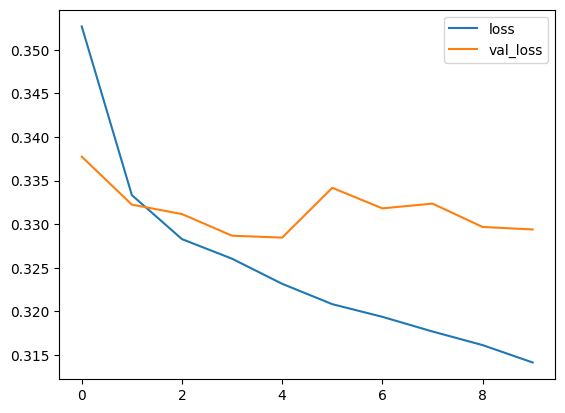

In [34]:
pd.DataFrame(history.history).plot()

In [35]:
X_jet_test_scaled = jet_scaler.transform(X_jet_test)
X_other_test_scaled = other_scaler.transform(X_other_test)
weight_test_scaled = transform_weight(weight_test, y_test)

In [36]:
y_pred_train = model.predict({"jets": X_jet_train_scaled, "other": X_other_train_scaled}, verbose=True)[:, 0]
y_pred_test = model.predict({"jets": X_jet_test_scaled, "other": X_other_test_scaled}, verbose=True)[:, 0]

5754/5754 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [37]:
from sklearn.metrics import roc_curve

In [38]:
from mltools import ams

In [39]:
def ams_scan(y, y_prob, weights, label):
    fpr, tpr, thr = roc_curve(y, y_prob, sample_weight=weights)
    ams_vals = ams(tpr * n_sig_tot, fpr * n_bkg_tot)
    print("{}: Maximum AMS {:.3f} for pcut {:.3f}".format(label, ams_vals.max(), thr[np.argmax(ams_vals)]))
    return thr, ams_vals

Train: Maximum AMS 3.752 for pcut 0.947
Test: Maximum AMS 3.690 for pcut 0.934


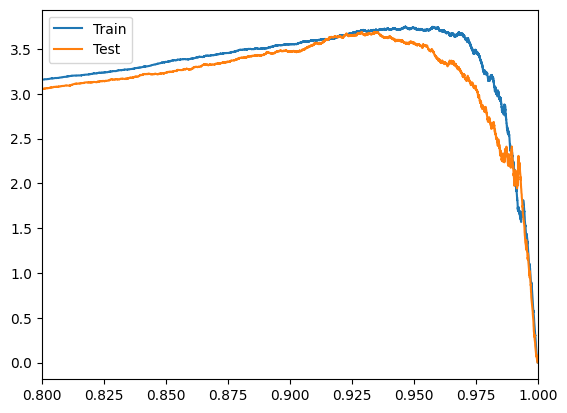

In [40]:
plt.plot(*ams_scan(y_train, y_pred_train, weight_train, "Train"), label="Train")
plt.plot(*ams_scan(y_test, y_pred_test, weight_test, "Test"), label="Test")
plt.xlim(0.8, 1.)
plt.legend()

<div class="alert alert-block alert-success">
    <h2>Exercise 1</h2>
    Obviously in such a composed model there are many options to play with concerning the detailed structure of the network (number of hidden layers, number of neurons)
</div>